In [36]:
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from keras.layers import Conv2D, SeparableConv2D, BatchNormalization, ReLU, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout
import os
from keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
import seaborn as sns
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings('ignore')

# **Read Training Data**

In [2]:
images = []

base_dir = '/kaggle/input/fer2013/train'
emotions = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

for emotion in emotions:
    emotion_dir = os.path.join(base_dir, emotion)
    for root, _, files in os.walk(emotion_dir):
        for file_name in files:
            file_path = os.path.join(root, file_name)
            
            image = cv2.imread(file_path)
            images.append(image)
                

In [3]:
train_data = pd.read_csv('/kaggle/input/emotion-labels/emotion_train.csv')
train_data.head()

,file_path,file_name,label
0,C:/Users/Mostafa/Desktop/Emotion-Recognition/D...,Training_10118481.jpg,angry
1,C:/Users/Mostafa/Desktop/Emotion-Recognition/D...,Training_10120469.jpg,angry
2,C:/Users/Mostafa/Desktop/Emotion-Recognition/D...,Training_10131352.jpg,angry
3,C:/Users/Mostafa/Desktop/Emotion-Recognition/D...,Training_10161559.jpg,angry
4,C:/Users/Mostafa/Desktop/Emotion-Recognition/D...,Training_1021836.jpg,angry


In [4]:
labels = train_data['label']
print(len(images))
print(len(labels))

28709
28709


In [5]:
images[0].shape

(48, 48, 3)

# **Preprocess Training Data**

In [6]:
label_map = {}
current_label = 0
numeric_labels = []

for char in labels:
    if char not in label_map:
        # If not, assign a new label
        label_map[char] = current_label
        current_label += 1
    numeric_labels.append(label_map[char])

In [7]:
label_map

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [8]:
one_hot_labels = to_categorical(numeric_labels)
print("Shape of One-Hot Encoded Labels:", one_hot_labels.shape)

Shape of One-Hot Encoded Labels: (28709, 7)


In [9]:
from sklearn.utils import shuffle
imgs, OHL = shuffle(images, one_hot_labels, random_state=42)

del images
del one_hot_labels

In [10]:
imgs = np.array(imgs, dtype=np.float32)
OHL = np.array(OHL, dtype=np.int32)

In [11]:
train_images, val_images, train_labels, val_labels = train_test_split(
    imgs, OHL, test_size=0.2, random_state=42,shuffle=False
)

In [12]:
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = datagen.flow(train_images, train_labels, batch_size=32)
val_generator = ImageDataGenerator(rescale=1./255).flow(val_images, val_labels, batch_size=32)


# **Train CNNational model**

In [15]:
CNN = Sequential()

# Block 1
CNN.add(Conv2D(16, (3, 3), padding='same', input_shape=(train_images.shape[1], train_images.shape[2], 3)))
CNN.add(BatchNormalization())
CNN.add(ReLU())
CNN.add(MaxPooling2D((2, 2)))
CNN.add(Dropout(0.2))  # Added Dropout

# Block 2
CNN.add(Conv2D(32, (3, 3), padding='same'))
CNN.add(BatchNormalization())
CNN.add(ReLU())
CNN.add(MaxPooling2D((2, 2)))
CNN.add(Dropout(0.3))  # Added Dropout

# Block 3
CNN.add(Conv2D(64, (3, 3), padding='same'))
CNN.add(BatchNormalization())
CNN.add(ReLU())
CNN.add(MaxPooling2D((2, 2)))
CNN.add(Dropout(0.4))  # Added Dropout

# Block 4
CNN.add(SeparableConv2D(128, (3, 3), padding='same'))
CNN.add(BatchNormalization())
CNN.add(ReLU())

# Block 5
CNN.add(SeparableConv2D(256, (3, 3), padding='same'))
CNN.add(BatchNormalization())
CNN.add(ReLU())
CNN.add(MaxPooling2D((2, 2)))
CNN.add(Dropout(0.5))  # Added Dropout

# Block 6
CNN.add(SeparableConv2D(512, (3, 3), padding='same'))
CNN.add(BatchNormalization())
CNN.add(ReLU())

# Global Average Pooling and Dense layer
CNN.add(GlobalAveragePooling2D())
CNN.add(Dense(7, activation='softmax'))

In [16]:
CNN.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
CNN.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48, 48, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 48, 48, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 24, 24, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 12, 12, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d                │ (None, 6, 6, 128)      │         8,896 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 6, 6, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_1              │ (None, 6, 6, 256)      │        34,176 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 6, 6, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_5 (ReLU)                  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 208,167 (813.15 KB)

 Trainable params: 206,151 (805.28 KB)

 Non-trainable params: 2,016 (7.88 KB)

In [18]:
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)

# Training the model
history = CNN.fit(
    train_generator, 
    validation_data=val_generator, 
    epochs=50, 
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/50


2024-06-23 07:02:13.982416: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 4.58646, expected 3.83177
2024-06-23 07:02:13.982472: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 5.89569, expected 5.141
2024-06-23 07:02:13.982487: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 5.52901, expected 4.77433
2024-06-23 07:02:13.982501: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 5.56236, expected 4.80767
2024-06-23 07:02:13.982519: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 5.24603, expected 4.49134
2024-06-23 07:02:13.982530: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 6.42779, expected 5.6731
2024-06-23 07:02:13.982543: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 7: 5.64771, expected 4.89302
2024-06-23 07:02:13.982554: E external/local_xla/xla/servi

  6/718 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.1557 - loss: 2.0010 

I0000 00:00:1719126140.974069     515 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


686/718 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.2330 - loss: 1.8338

2024-06-23 07:02:45.914716: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6912: 4.85724, expected 4.25816
2024-06-23 07:02:45.914800: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6920: 4.73732, expected 4.13824
2024-06-23 07:02:45.914815: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6921: 4.10419, expected 3.50511
2024-06-23 07:02:45.914829: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6922: 4.56343, expected 3.96435
2024-06-23 07:02:45.914849: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6931: 4.76366, expected 4.16458
2024-06-23 07:02:45.914866: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6938: 4.57145, expected 3.97237
2024-06-23 07:02:45.914877: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6945: 4.72226, expected 4.12318
2024-06-23 07:02:45.914887: E exte

711/718 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.2334 - loss: 1.8332

2024-06-23 07:03:06.900080: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2304: 4.48375, expected 3.71382
2024-06-23 07:03:06.900140: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2306: 5.55293, expected 4.78299
2024-06-23 07:03:06.900149: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2307: 4.35861, expected 3.58867
2024-06-23 07:03:06.900157: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2308: 5.74009, expected 4.97015
2024-06-23 07:03:06.900164: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2309: 6.64496, expected 5.87502
2024-06-23 07:03:06.900172: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2311: 6.17532, expected 5.40539
2024-06-23 07:03:06.900179: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2312: 3.75883, expected 2.98889
2024-06-23 07:03:06.900187: E exte

718/718 ━━━━━━━━━━━━━━━━━━━━ 62s 65ms/step - accuracy: 0.2335 - loss: 1.8330 - val_accuracy: 0.2722 - val_loss: 1.7877 - learning_rate: 0.0010
Epoch 2/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 22s 31ms/step - accuracy: 0.2604 - loss: 1.7866 - val_accuracy: 0.3023 - val_loss: 1.7286 - learning_rate: 0.0010
Epoch 3/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 23s 31ms/step - accuracy: 0.2904 - loss: 1.7402 - val_accuracy: 0.2734 - val_loss: 1.8801 - learning_rate: 0.0010
Epoch 4/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 23s 31ms/step - accuracy: 0.3104 - loss: 1.7095 - val_accuracy: 0.3979 - val_loss: 1.5468 - learning_rate: 0.0010
Epoch 5/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 23s 31ms/step - accuracy: 0.3396 - loss: 1.6653 - val_accuracy: 0.4263 - val_loss: 1.5018 - learning_rate: 0.0010
Epoch 6/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 23s 31ms/step - accuracy: 0.3543 - loss: 1.6291 - val_accuracy: 0.4133 - val_loss: 1.5449 - learning_rate: 0.0010
Epoch 7/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 22s 31ms/step - accuracy: 0.3723 - loss: 1.5998

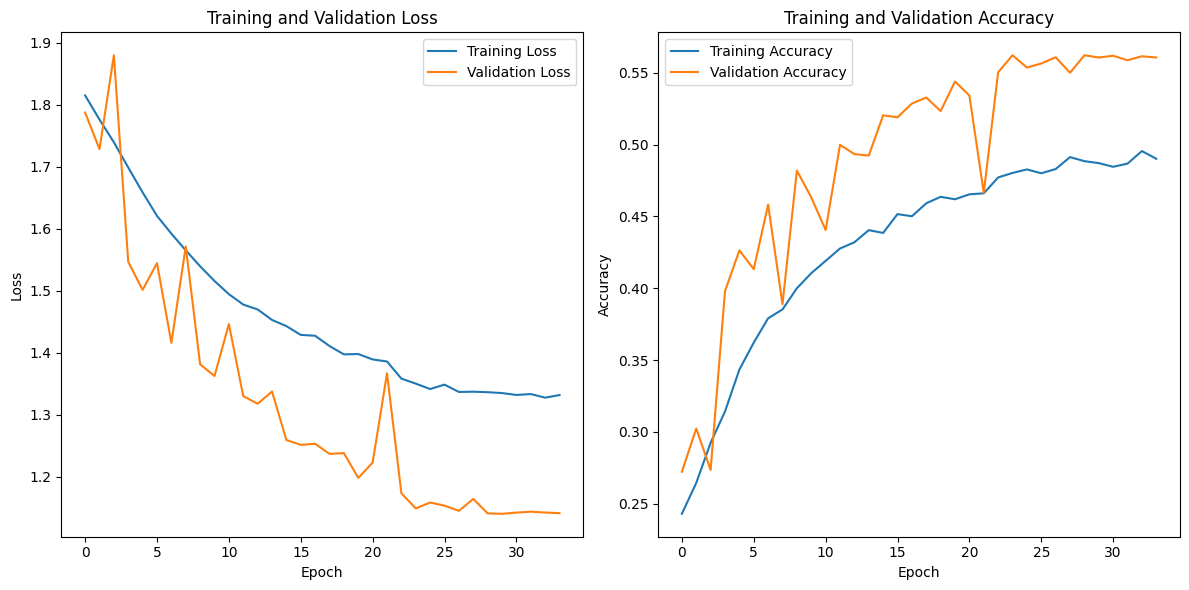

In [19]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

# Plotting the loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting the accuracy
plt.subplot(1, 2, 2)
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# **Read Test Data**

In [20]:
t_images = []

t_base_dir = '/kaggle/input/fer2013/test'

for emotion in emotions:
    emotion_dir = os.path.join(t_base_dir, emotion)
    for root, _, files in os.walk(emotion_dir):
        for file_name in files:
            file_path = os.path.join(root, file_name)
            
            image = cv2.imread(file_path)
            t_images.append(image)
                

In [21]:
test_data = pd.read_csv('/kaggle/input/emotion-labels/emotion_test.csv')
test_data.head()

,file_path,file_name,label
0,C:/Users/Mostafa/Desktop/Emotion-Recognition/D...,PrivateTest_10131363.jpg,angry
1,C:/Users/Mostafa/Desktop/Emotion-Recognition/D...,PrivateTest_10304478.jpg,angry
2,C:/Users/Mostafa/Desktop/Emotion-Recognition/D...,PrivateTest_1054527.jpg,angry
3,C:/Users/Mostafa/Desktop/Emotion-Recognition/D...,PrivateTest_10590091.jpg,angry
4,C:/Users/Mostafa/Desktop/Emotion-Recognition/D...,PrivateTest_1109992.jpg,angry


In [22]:
t_labels = test_data['label']
print(len(t_images))
print(len(t_labels))

7178
7178


In [29]:
t_label_map = {}
t_current_label = 0
t_numeric_labels = []

for char in t_labels:
    if char not in t_label_map:
        # If not, assign a new label
        t_label_map[char] = t_current_label
        t_current_label += 1
    t_numeric_labels.append(t_label_map[char])
    
    
# t_one_hot_labels = to_categorical(t_numeric_labels)

t_imgs, t_OHL = shuffle(t_images, t_numeric_labels, random_state=42)

X_test = np.array(t_imgs, dtype=np.float32)
y_test = np.array(t_OHL, dtype=np.int32)

In [30]:
y_hat=CNN.predict(X_test)

225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [31]:
len(y_hat)

7178

In [33]:
predicted_classes = [np.argmax(pred) for pred in y_hat]

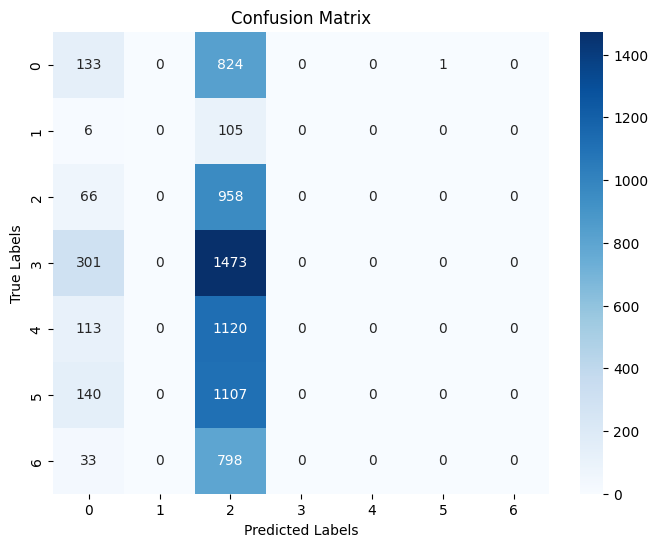

In [37]:
conf_matrix = confusion_matrix(y_test, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [38]:
from collections import Counter
Counter(predicted_classes)

Counter({2: 6385, 0: 792, 5: 1})